In [1]:
import torch
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from main import focal_loss,plot_training_metrics,label_smoothing_loss,train,super_class_mapping,class_to_superclass
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Available GPUs: {num_gpus}")

# Print PyTorch and torchvision versions
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)


使用设备: cuda
Available GPUs: 1
PyTorch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [3]:
# Set the random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Ensure that DataLoader workers use the same random seed
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the random seed to ensure reproducibility
set_seed(8)


In [4]:
# Training set image preprocessing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop to 32x32 with 4 pixels of padding around the edges
    transforms.RandomHorizontalFlip(),     # Random horizontal flip
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],  # Mean of CIFAR-100
        std=[0.2675, 0.2565, 0.2761]    # Standard deviation of CIFAR-100
    )
])

# Test set image preprocessing (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],  # Mean of CIFAR-100
        std=[0.2675, 0.2565, 0.2761]    # Standard deviation of CIFAR-100
    )
])


In [5]:
root_path = 'data'

# Load the CIFAR-100 training dataset
trainset = torchvision.datasets.CIFAR100(root=root_path, train=True, download=True, transform=train_transform)

# Create a DataLoader for the training dataset, with worker_init_fn to ensure reproducibility
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=128, 
    shuffle=True, 
    num_workers=2, 
    worker_init_fn=seed_worker  # Ensure reproducibility of the random seed for each worker
)

# Load the CIFAR-100 test dataset
testset = torchvision.datasets.CIFAR100(root=root_path, train=False, download=True, transform=test_transform)

# Create a DataLoader for the test dataset, also with worker_init_fn
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=128, 
    shuffle=False, 
    num_workers=2, 
    worker_init_fn=seed_worker  # Ensure reproducibility of the random seed for each worker
)

)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Print the size of the training and test datasets
print(f"Training dataset size: {len(trainset)}")
print(f"Test dataset size: {len(testset)}")


训练数据集的大小: 50000
测试数据集的大小: 10000


In [7]:
from Wide_ResNet import WideResNet

resnet = WideResNet(depth=28, widen_factor=10, num_classes=100)
resnet.to('cuda')

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): WideBlock(
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.3, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): WideBlock(
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(

In [8]:
def train(model, trainloader, testloader, criterion, optimizer, scheduler, super_class_mapping, class_to_superclass, device='cpu', num_epochs=100):
    """
    Train the model and calculate and print Top-1 accuracy, Top-5 accuracy, and Super-Class accuracy.
    Outputs the best metrics observed during training.
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    best_test_accuracy = 0.0
    best_epoch_metrics = {}

    # 用于保存上一轮学习率
    previous_lr = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_super_class_train = 0
        total_super_class_train = 0

        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Calculate super-class accuracy (optional)
            for idx, label in enumerate(labels):
                superclass = class_to_superclass[label.item()]
                total_super_class_train += 1
                if predicted[idx].item() in super_class_mapping[superclass]:
                    correct_super_class_train += 1

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        correct_top5 = 0
        correct_super_class_test = 0
        total_super_class_test = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

                _, top5_preds = outputs.topk(5, dim=1)
                correct_top5 += (top5_preds == labels.view(-1, 1)).sum().item()

                # Calculate super-class accuracy (optional)
                for idx, label in enumerate(labels):
                    superclass = class_to_superclass[label.item()]
                    total_super_class_test += 1
                    if predicted[idx].item() in super_class_mapping[superclass]:
                        correct_super_class_test += 1

        test_loss = running_test_loss / len(testloader)
        test_accuracy = 100 * correct_test / total_test
        top5_accuracy = 100 * correct_top5 / total_test
        super_class_accuracy_test = 100 * correct_super_class_test / total_super_class_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.3f}, '
              f'Test Acc: {test_accuracy:.2f}%, Top-5 Acc: {top5_accuracy:.2f}%, Super-Class Acc: {super_class_accuracy_test:.2f}%')

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # 如果学习率发生变化，则打印新的学习率
        if previous_lr is None or current_lr != previous_lr:
            print(f'Learning Rate changed to: {current_lr:.6f}')

        # 更新 previous_lr
        previous_lr = current_lr

        # Store best accuracy and corresponding metrics
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch_metrics = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'top5_accuracy': top5_accuracy,
                'super_class_accuracy': super_class_accuracy_test
            }

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f'Finished Training in {int(minutes)}m {int(seconds)}s')

    # Output best results
    print('Best Test Results:')
    print(f'Epoch {best_epoch_metrics["epoch"]}, Train Loss: {best_epoch_metrics["train_loss"]:.3f}, Train Acc: {best_epoch_metrics["train_accuracy"]:.2f}%, '
          f'Test Loss: {best_epoch_metrics["test_loss"]:.3f}, Test Acc: {best_epoch_metrics["test_accuracy"]:.2f}%, '
          f'Top-5 Acc: {best_epoch_metrics["top5_accuracy"]:.2f}%, Super-Class Acc: {best_epoch_metrics["super_class_accuracy"]:.2f}%')

    return best_epoch_metrics, train_losses, test_losses, train_accuracies, test_accuracies


In [10]:
from torch.optim.lr_scheduler import MultiStepLR
import time

optimizer = optim.SGD(
    resnet.parameters(),
    lr=0.1,              # Initial learning rate (typically the maximum learning rate)
    momentum=0.9,
    weight_decay=0.0005,
    nesterov=True
)

# Instantiate the cross-entropy loss function
criterion = nn.CrossEntropyLoss()

scheduler = MultiStepLR(optimizer, milestones=[58, 64, 67, 74], gamma=0.2)

# Call the training function
e, train_losses, test_losses, train_accuracies, test_accuracies = train(
    resnet,
    trainloader,
    testloader,
    criterion,            # Use cross-entropy loss
    optimizer,
    scheduler,            # Add scheduler parameter
    super_class_mapping,  # Add super_class_mapping
    class_to_superclass,  # Add class_to_superclass
    device='cuda',
    num_epochs=80,        
)


Epoch 1/80, Train Loss: 4.790, Train Acc: 2.03%, Test Loss: 4.332, Test Acc: 3.80%, Top-5 Acc: 14.52%, Super-Class Acc: 11.39%
Learning Rate changed to: 0.100000
Epoch 2/80, Train Loss: 4.076, Train Acc: 6.33%, Test Loss: 3.842, Test Acc: 9.47%, Top-5 Acc: 30.42%, Super-Class Acc: 21.42%
Epoch 3/80, Train Loss: 3.690, Train Acc: 11.94%, Test Loss: 3.467, Test Acc: 15.41%, Top-5 Acc: 43.71%, Super-Class Acc: 29.46%
Epoch 4/80, Train Loss: 3.323, Train Acc: 18.54%, Test Loss: 3.173, Test Acc: 22.35%, Top-5 Acc: 51.19%, Super-Class Acc: 36.05%
Epoch 5/80, Train Loss: 2.990, Train Acc: 25.20%, Test Loss: 2.933, Test Acc: 27.29%, Top-5 Acc: 58.04%, Super-Class Acc: 42.27%
Epoch 6/80, Train Loss: 2.656, Train Acc: 31.65%, Test Loss: 2.690, Test Acc: 32.43%, Top-5 Acc: 64.11%, Super-Class Acc: 47.95%
Epoch 7/80, Train Loss: 2.330, Train Acc: 38.57%, Test Loss: 2.346, Test Acc: 39.67%, Top-5 Acc: 72.18%, Super-Class Acc: 53.54%
Epoch 8/80, Train Loss: 2.071, Train Acc: 44.13%, Test Loss: 2.325

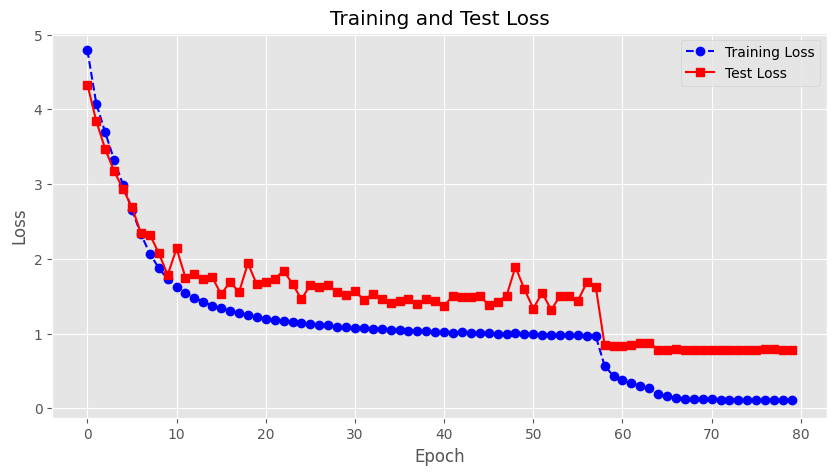

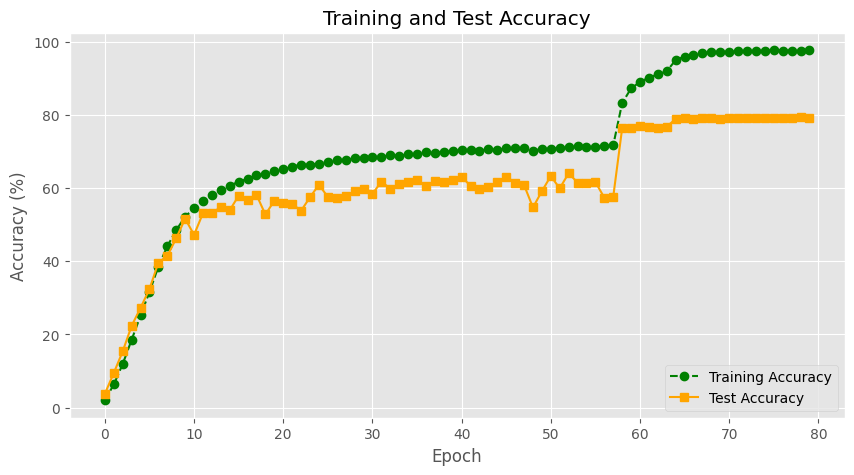

In [11]:
plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies)